In [1]:
# Import necessary modules
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import seaborn as sns 
import os
import sys
import time
import math
import re
import string
from bs4 import BeautifulSoup
import pickle
import joblib
from joblib import dump, load

import nltk as nltk
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import spacy 
from spacy import displacy
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from pprint import pprint
import gensim
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

from bertopic import BERTopic
import ipywidgets

from pandarallel import pandarallel
import multiprocessing
from multiprocessing import Pool

import warnings
warnings.filterwarnings(action = 'ignore', category = UserWarning, module = 'gensim')

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)
%matplotlib inline

2023-05-27 02:24:36.471857: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-27 02:24:39.155701: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-05-27 02:24:39.155842: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/

In [2]:
num_processors = multiprocessing.cpu_count()
workers = num_processors-1
print(f'Available CPUs: {num_processors}')

Available CPUs: 96


In [3]:
pandarallel.initialize(progress_bar=True, nb_workers=num_processors-1, use_memory_fs=False)

INFO: Pandarallel will run on 95 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [4]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [5]:
%%time
df = pd.read_parquet('df.parquet', engine = 'pyarrow')
df.shape

CPU times: user 4.7 s, sys: 3.04 s, total: 7.74 s
Wall time: 7.66 s


(200284, 3)

In [6]:
df.head()

,date,clean_title,clean_text
0,2021-03-18,Artificial intelligence improves parking efficiency in Chinese cities - People's Daily Online,Artificial intelligence improves parking efficiency in Chinese cities - People's Daily Online Ho...
1,2020-02-27,Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Rob...,Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Rob...
2,2021-03-26,"Forget ML, AI and Industry 4.0 – obsolescence should be your focus - 26 February 2021 - Test & R...","Forget ML, AI and Industry 4.0 – obsolescence should be your focus - 26 February 2021 - Test & R..."
3,2021-03-10,Strategy Analytics: 71% of Smartphones Sold Globally in 2021 will be AI Powered – Consumer Elect...,Strategy Analytics: 71% of Smartphones Sold Globally in 2021 will be AI Powered – Consumer Elect...
4,2020-10-20,Olympus to Support Endoscopic AI Diagnosis Education for Doctors in India and to Launch AI Diagn...,Olympus to Support Endoscopic AI Diagnosis Education for Doctors in India and to Launch AI Diagn...


# Topic Modeling

## Using Latent Dirichlet Allocation (LDA)

In [7]:
df_topic = df.copy()
df_topic.shape

(200284, 3)

In [8]:
df_topic.head()

,date,clean_title,clean_text
0,2021-03-18,Artificial intelligence improves parking efficiency in Chinese cities - People's Daily Online,Artificial intelligence improves parking efficiency in Chinese cities - People's Daily Online Ho...
1,2020-02-27,Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Rob...,Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Rob...
2,2021-03-26,"Forget ML, AI and Industry 4.0 – obsolescence should be your focus - 26 February 2021 - Test & R...","Forget ML, AI and Industry 4.0 – obsolescence should be your focus - 26 February 2021 - Test & R..."
3,2021-03-10,Strategy Analytics: 71% of Smartphones Sold Globally in 2021 will be AI Powered – Consumer Elect...,Strategy Analytics: 71% of Smartphones Sold Globally in 2021 will be AI Powered – Consumer Elect...
4,2020-10-20,Olympus to Support Endoscopic AI Diagnosis Education for Doctors in India and to Launch AI Diagn...,Olympus to Support Endoscopic AI Diagnosis Education for Doctors in India and to Launch AI Diagn...


In [9]:
%%time

# Tokenize text into words and remove punctuation
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data_list = df_topic['clean_text'].tolist()        
data_tokens = list(sent_to_words(data_list))

CPU times: user 8min 30s, sys: 11.5 s, total: 8min 42s
Wall time: 8min 42s


In [10]:
%%time
bigram = gensim.models.Phrases(data_tokens, min_count=1, threshold=1)
trigram = gensim.models.Phrases(bigram[data_tokens], threshold=1)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

CPU times: user 13min 41s, sys: 22.2 s, total: 14min 3s
Wall time: 14min 3s


In [11]:
%%time
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

CPU times: user 4.16 ms, sys: 5 µs, total: 4.17 ms
Wall time: 2.74 ms


In [14]:
%%time
# Remove Stop Words
data_tokens_nostops = remove_stopwords(data_tokens)

# Create n-grams
data_words_bigrams = make_bigrams(data_tokens_nostops)
data_words_trigrams = make_trigrams(data_tokens_nostops)

# Combine tokens and n-grams
# data_tokens_combined = data_tokens_nostops + data_words_bigrams + data_words_trigrams
data_tokens_combined = data_words_trigrams

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en_core_web_lg', disable=['parser', 'ner'])

# Lemmatize text keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_tokens_combined, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# print(*data_lemmatized[:1])

# 1hr 27mins

CPU times: user 1h 51min 52s, sys: 3min 3s, total: 1h 54min 55s
Wall time: 1h 54min 55s


In [15]:
# Save data_lemmatized as a file using pickle
with open('data_lemmatized.pkl', 'wb') as f:
    pickle.dump(data_lemmatized, f)

In [16]:
# Load data_lemmatized from the saved file
with open('data_lemmatized.pkl', 'rb') as f:
    data_lemmatized = pickle.load(f)

In [ ]:
# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(data_lemmatized)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in data_lemmatized]

In [ ]:
# Tune LDA model
def compute_coherence_values(corpus, dictionary, k, a, b):
    lda_model = LdaMulticore(corpus=doc_term_matrix,
                       id2word=dictionary,
                       num_topics=k,
                       random_state=100,                  
                       passes=10,
                       alpha=a,
                       eta=b,
                       workers=workers)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [19]:
%%time
grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 10
step_size = 1
topics_range = range(min_topics, max_topics+1, step_size)

# Alpha parameter
# alpha = list(np.arange(0.01, 1, 0.3))
# alpha.append('symmetric')
# alpha.append('asymmetric')
alpha = ['asymmetric'] # Run for number of topics only

# Beta parameter
# beta = list(np.arange(0.01, 1, 0.3))
# beta.append('symmetric')
beta = ['auto'] # Run for number of topics only

# Validation sets
num_of_docs = len(doc_term_matrix)
corpus_sets = [doc_term_matrix]
corpus_title = ['100% Corpus']
model_results = {
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
itr = 0
itr_total = len(beta)*len(alpha)*len(topics_range)*len(corpus_title)
print(f'LDA will execute {itr_total} iterations')

# iterate through hyperparameters
for i in range(len(corpus_sets)):
    
    # iterate through number of topics
    for k in topics_range:
        
        # iterate through alpha values
        for a in alpha:
            
            # iterare through beta values
            for b in beta:
                
                # get the coherence score for the given parameters
                itr += 1
                cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary, k=k, a=a, b=b)
                
                # Save the model results
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(cv)
                pct_completed = round((itr / itr_total * 100),1)
#                 print(f'Completed Percent: {pct_completed}%, Corpus: {corpus_title[i]}, Topics: {k}, Alpha: {a}, Beta: {b}, Coherence: {cv}')
        print(f'Completed model based on {k} LDA topics. Finished {pct_completed}% of LDA runs')
                            
lda_tuning = pd.DataFrame(model_results)

# 1hr 44mins

Completed model based on 2 LDA topics. Finished 11.1% of LDA runs
Completed model based on 3 LDA topics. Finished 22.2% of LDA runs
Completed model based on 4 LDA topics. Finished 33.3% of LDA runs
Completed model based on 5 LDA topics. Finished 44.4% of LDA runs
Completed model based on 6 LDA topics. Finished 55.6% of LDA runs
Completed model based on 7 LDA topics. Finished 66.7% of LDA runs
Completed model based on 8 LDA topics. Finished 77.8% of LDA runs
Completed model based on 9 LDA topics. Finished 88.9% of LDA runs
Completed model based on 10 LDA topics. Finished 100.0% of LDA runs
CPU times: user 1h 13min 2s, sys: 55min 33s, total: 2h 8min 36s
Wall time: 2h 10min 11s


In [20]:
lda_tuning.head()

,Topics,Alpha,Beta,Coherence
0,2,asymmetric,auto,0.366391
1,3,asymmetric,auto,0.378532
2,4,asymmetric,auto,0.362536
3,5,asymmetric,auto,0.345876
4,6,asymmetric,auto,0.332175


In [21]:
lda_tuning.to_csv("lda_topics.csv")

In [22]:
lda_tuning.sort_values(by=['Coherence'], ascending=False).head(10)

,Topics,Alpha,Beta,Coherence
1,3,asymmetric,auto,0.378532
0,2,asymmetric,auto,0.366391
2,4,asymmetric,auto,0.362536
3,5,asymmetric,auto,0.345876
4,6,asymmetric,auto,0.332175
5,7,asymmetric,auto,0.319926
6,8,asymmetric,auto,0.319237
8,10,asymmetric,auto,0.319189
7,9,asymmetric,auto,0.316381


<AxesSubplot: title={'center': 'Overall LDA Tuning'}, xlabel='Topics'>

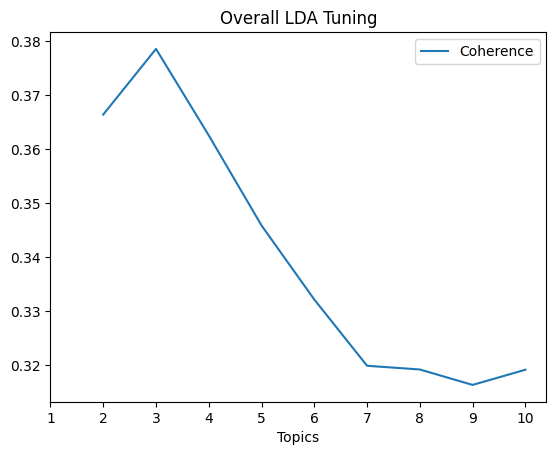

In [23]:
lda_tuning.plot(x ='Topics', y='Coherence', title = 'Overall LDA Tuning',kind = 'line', xticks=range(1,11))

In [24]:
lda_tuning_best = lda_tuning.sort_values(by=['Coherence'], ascending=False).head(1)
tuned_topics = int(lda_tuning_best['Topics'].to_string(index=False))

# Since the values for Alpha and Beta can be float, symmetric and asymmetric, we will either strip or convert to float
try:
    tuned_alpha = float(lda_tuning_best['Alpha'].to_string(index=False))
except:
    tuned_alpha = lda_tuning_best['Alpha'].to_string(index=False).strip()
try:
    tuned_beta = float(lda_tuning_best['Beta'].to_string(index=False))
except:
    tuned_beta = lda_tuning_best['Beta'].to_string(index=False).strip()    
    
print(f'Best Parameters: Topics: {tuned_topics}, Alpha: {tuned_alpha}, Beta: {tuned_beta}')

Best Parameters: Topics: 3, Alpha: asymmetric, Beta: auto


In [25]:
best_lda = LdaMulticore(corpus=doc_term_matrix,
                   id2word=dictionary,
                   num_topics=4,
                   random_state=100,
                   passes=10,
                   alpha='asymmetric',
                   eta='auto',
                   workers=workers)

In [26]:
lda_display = gensimvis.prepare(best_lda, doc_term_matrix, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display)